In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Implemented from scratch (check other files)
from kmeans import K_Means
from svd import SVD

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
data = pd.read_excel('data/Course Recommendation System(1-162).xlsx')
data = data.drop(data.iloc[:, 0:6], axis=1) # Delete unnecessary columns

data_core = data.iloc[:, :5]

courses = list(data.columns)
core_courses = list(data_core.columns)
elective_courses = list(data.iloc[:, 5:].columns)

In [3]:
X_orig = data.to_numpy()
X = data.fillna(0.5).to_numpy()

X, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [4]:
Svd = SVD(X[:, :5])
u, s, vh = Svd.return_trunc_matrices(X[:, :5], 2)
X_SVD = np.dot(u @ s, vh).T

X_core = X_SVD[:, :5]
X_electives = X_SVD[:, 5:]

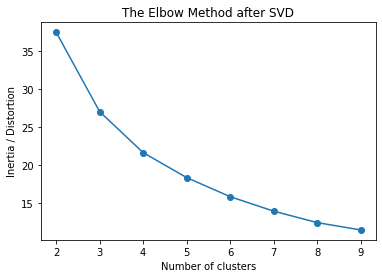

In [5]:
Inertia = []

for i in range(2, 10):
	kmeans = K_Means(i, 10)
	kmeans.fit(X_core, 100)
	Inertia.append(kmeans.inertia)

plt.plot(range(2, 10), Inertia, 'o-')
plt.xticks(range(2, 10))
plt.title('The Elbow Method after SVD')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia / Distortion')
plt.show()

X_core contains our user vectors (ratings for each user in the core courses)

In [6]:
def Pca(n):
	pca = PCA(n_components=n).fit(X_core)

	print(pca.explained_variance_ratio_.cumsum())
	kmeans_reduced = pca.transform(X_core)
	
	Inertia = []

	for i in range(2, 10):
		kmeans = K_Means(i, 10)
		kmeans.fit(kmeans_reduced, 75)
		Inertia.append(kmeans.inertia)

	plt.plot(range(2, 10), Inertia, 'o-')
	plt.xticks(range(2, 10))
	plt.title(f'The Elbow Method (After PCA reduction to {n} dim)')
	plt.xlabel('Number of clusters')
	plt.ylabel('Inertia / Distortion')
	plt.show()

[0.42955609 0.81717196]


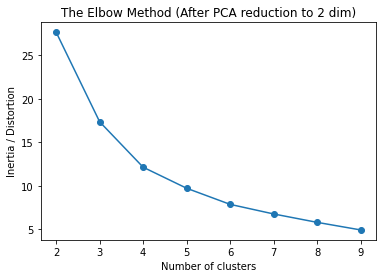

In [7]:
Pca(2)

[0.42955609]


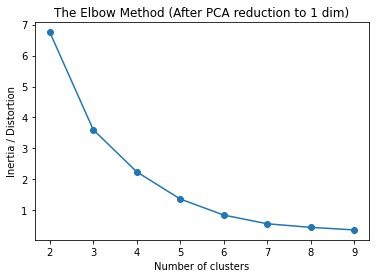

In [8]:
Pca(1)

In [9]:
n_clusters = 5
n_init = 10
kmeans = K_Means(n_clusters, n_init)
kmeans.fit(X_core, 100)
kmeans.get_cluster_size()

cluster_assignment = kmeans.c_assignment

In [10]:
Svd = SVD(X)
u, s, vh = Svd.return_trunc_matrices(X, 1)
X_SVD = np.dot(u @ s, vh).T

In [11]:
X_comp = np.zeros((1, 25))

for i in range(n_clusters):
    mean = np.mean(X_SVD[np.where(cluster_assignment == i)], axis=0).reshape(1, -1)
    X_comp = np.vstack((X_comp, mean))
    
X_comp = X_comp[1:, :]

In [12]:
u, s, vh = np.linalg.svd(X_comp, full_matrices=False)
np.allclose(X_comp, np.dot(u * s, vh))

Svd = SVD(X_comp)
u, s, vh = Svd.return_trunc_matrices(X_comp, 1)

X_svd = np.dot(u @ s, vh)

In [13]:
def get_predictions(n, X):
	recs = {}
	for i in range(X.shape[0]):
		ind = np.argpartition(X[i, :], -n)[-n:]
		ind = ind[np.argsort(X_svd[i, :][ind])]
		print("Cluster - ", i + 1, "\n")
		print(X_svd[i, :][ind][::-1])
		print([elective_courses[i] for i in ind[::-1]], "\n")
		recs[i] = [[elective_courses[i] for i in ind[::-1]], [X_svd[i, :][ind][::-1]]]

	return recs

recommendations = get_predictions(5, X_svd[:, 5:])

Cluster -  1 

[0.83786505 0.78314109 0.58941131 0.42492411 0.33445271]
['Software Production Engineering\n', 'Machine Learning\n', 'Programming Languages\n', 'Visual Recognition\n', 'Mathematics For Machine Learning\n'] 

Cluster -  2 

[0.76785069 0.70073231 0.57813453 0.49351848 0.42311467]
['Natural Language Processing\n', 'Software Production Engineering\n', 'Data Visualization\n', 'Reinforcement Learning', 'Machine Learning\n'] 

Cluster -  3 

[0.95627836 0.91191787 0.87833381 0.85441175 0.18596952]
['Machine Learning\n', 'Mathematics For Machine Learning\n', 'Reinforcement Learning', 'Software Production Engineering\n', 'Natural Language Processing\n'] 

Cluster -  4 

[0.72653585 0.71685363 0.4886245  0.4074662  0.29012723]
['Software Production Engineering\n', 'Machine Learning\n', 'Cloud Computing\n', 'Mathematics For Machine Learning\n', 'Visual Recognition\n'] 

Cluster -  5 

[0.8798451  0.81912042 0.7857396  0.5927361  0.44287764]
['Machine Learning\n', 'Mathematics For 

In [14]:
def get_mse(x, x_pred):

	mse = 0
	for p in x:
		c = kmeans.find_cluster(kmeans.clusters, p[:5])
		predictions = x_pred[c]

		temp = 0
		count = 0
		for i in range(p.shape[0]):
			if not np.isnan(p[i]): 
				count += 1
				temp += ((p[i] - predictions[i])**2)
				
		mse += (temp / count)
	return mse / x.shape[0]

In [15]:
mse = []

for i in range(n_clusters):
	Svd = SVD(X_comp)
	u, s, vh = Svd.return_trunc_matrices(X_comp, i)

	X_svd = np.dot(u @ s, vh)
	mse.append(get_mse(X_orig, X_svd))

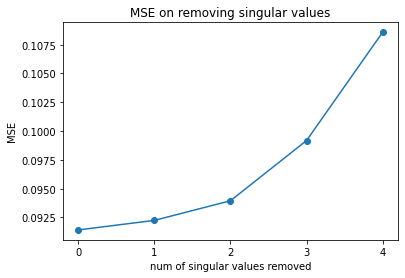

In [16]:
plt.plot(range(5), mse, 'o-')
plt.xticks(range(5))
plt.title('MSE on removing singular values')
plt.xlabel('num of singular values removed')
plt.ylabel('MSE')
plt.show()

In [17]:
def get_recommendations(p):
    c = kmeans.find_cluster(kmeans.clusters, p)
    return recommendations[c]

In [18]:
def get_accuracy(n, X, X_pred):
	temp = []
	acc = 0
	for i in range(X.shape[0]):

		pred = get_recommendations(X_core[i])
		
		ind = np.argpartition(X[i, :], -n)[-n:]
		ind = ind[np.argsort(X[i, :][ind])]
		true = [elective_courses[i] for i in ind[::-1]]

		for i in pred:
			for j in true:
				if i == j:
					acc += 1

	return  (acc / (5 * X.shape[0])) * 100

In [19]:
def K_vs_Accuracy(k):

	Svd = SVD(X[:, :5])
	u, s, vh = Svd.return_trunc_matrices(X, 1)
	X_SVD = np.dot(u @ s, vh).T
	X_core = X_SVD[:, :5]
	X_electives = X_SVD[:, 5:]
	
	n_clusters = k
	n_init = 10
	kmeans = K_Means(n_clusters, n_init)
	kmeans.fit(X_core, 100)
	kmeans.get_cluster_size()
	cluster_assignment = kmeans.c_assignment

	X_comp = np.zeros((1, 25))
	for i in range(n_clusters):
		mean = np.mean(X_SVD[np.where(cluster_assignment == i)], axis=0).reshape(1, -1)
		X_comp = np.vstack((X_comp, mean))

	X_comp = X_comp[1:, :]

	num_elect = 5
	acc_percent = []
	for i in range(1):
		Svd = SVD(X_comp)
		u, s, vh = Svd.return_trunc_matrices(X_comp, i)
		X_svd = np.dot(u @ s, vh)
		
		recs = {}
		for i in range(X_svd[:, 5:].shape[0]):
			ind = np.argpartition(X_svd[:, 5:][i, :], -num_elect)[-num_elect:]
			ind = ind[np.argsort(X_svd[i, :][ind])]
			recs[i] = [elective_courses[i] for i in ind[::-1]]

		acc = 0
		for i in range(X_SVD.shape[0]):

			pred = recs[kmeans.find_cluster(kmeans.clusters, X_SVD[i, :5])]

			ind = np.argpartition(X_SVD[i, 5:], -num_elect)[-num_elect:]
			ind = ind[np.argsort(X_SVD[i, 5:][ind])]
			true = [elective_courses[i] for i in ind[::-1]]

			for i in pred:
				for j in true:
					if i == j:
						acc += 1

		acc_percent.append((acc / (num_elect * X_SVD.shape[0])) * 100)
	return  acc_percent

In [20]:
result = [K_vs_Accuracy(i) for i in range(2, 9)]

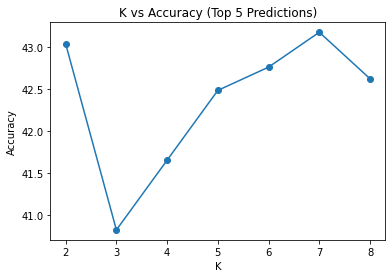

In [21]:
plt.plot(range(2,9), result, 'o-')
plt.xticks(range(2,9))
plt.title('K vs Accuracy (Top 5 Predictions)')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

### Real Time Inference

In [22]:
datapoint = [
		0.8,		# Data Structures and Algorithms
 		0.3,		# Computer Architecture
 		0.6,		# Discrete Mathematics
 		0.9,		# Economics
 		0.8,		# Programming-2
]

get_recommendations(datapoint)

[['Software Production Engineering\n',
  'Machine Learning\n',
  'Cloud Computing\n',
  'Mathematics For Machine Learning\n',
  'Visual Recognition\n'],
 [array([0.72653585, 0.71685363, 0.4886245 , 0.4074662 , 0.29012723])]]

In [23]:
datapoint = [
		0,		# Data Structures and Algorithms
 		0,		# Computer Architecture
 		0,		# Discrete Mathematics
 		0,		# Economics
 		0,		# Programming-2
]

get_recommendations(datapoint)

[['Software Production Engineering\n',
  'Machine Learning\n',
  'Programming Languages\n',
  'Visual Recognition\n',
  'Mathematics For Machine Learning\n'],
 [array([0.83786505, 0.78314109, 0.58941131, 0.42492411, 0.33445271])]]

In [24]:
datapoint = [
		1,		# Data Structures and Algorithms
 		1,		# Computer Architecture
 		1,		# Discrete Mathematics
 		1,		# Economics
 		1,		# Programming-2
]

get_recommendations(datapoint)

[['Machine Learning\n',
  'Mathematics For Machine Learning\n',
  'Software Production Engineering\n',
  'Data Visualization\n',
  'The Web and the Mind '],
 [array([0.8798451 , 0.81912042, 0.7857396 , 0.5927361 , 0.44287764])]]

In [25]:
datapoint = [
		0.5,		# Data Structures and Algorithms
 		0.5,		# Computer Architecture
 		0.5,		# Discrete Mathematics
 		0.5,		# Economics
 		0.5,		# Programming-2
]

get_recommendations(datapoint)

# reinforcement(10th course in list that is why 9)
X_comp[:, 9].mean() # Shows why REINFORCEMENT MIGHT BE A POSSIBLE OUTCOME OF SUCH DATAPOINT as asked in Presentation

[['Natural Language Processing\n',
  'Software Production Engineering\n',
  'Data Visualization\n',
  'Reinforcement Learning',
  'Machine Learning\n'],
 [array([0.76785069, 0.70073231, 0.57813453, 0.49351848, 0.42311467])]]